In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from statistics import mean, stdev
import openpyxl
import os
import shutil

## Functions

In [2]:
def create_line_chart(case, ws, row, chart_title, x_title, y_title1, y_title2):
    chart = LineChart()
    vals = Reference(ws, min_col = 2, min_row = 2, max_col = 2, max_row = row)
    x_values = Reference(ws, min_col = 1, min_row = 3, max_col = 1, max_row = row)
    chart.set_categories(x_values)
    chart.add_data(vals, titles_from_data = True)
    chart.x_axis.title = x_title
    chart.y_axis.title = y_title1
    chart.y_axis.majorGridlines = None
    chart.title = chart_title

    chart2 = LineChart()
    vals2 = Reference(ws, min_col = 4, min_row = 2, max_col = 4, max_row = row)
    x_values2 = Reference(ws, min_col = 1, min_row = 3, max_col = 1, max_row = row)
    chart2.add_data(vals2, titles_from_data = True)
    chart2.y_axis.axId = 200
    chart2.set_categories(x_values2)
    chart2.y_axis.title = y_title2
    chart2.y_axis.majorGridlines = None

    chart.y_axis.crosses = "max"
    chart += chart2
    ws.add_chart(chart, "H8")

#Standard score standardization shifts the mean to 0 and ensures that the stdev is 1.0. 
def standard_score_normalization(dictionary): 
    """Take a dataset in the form of a dicitonary as an arg and return a standardized dataset."""
    cases = list(dictionary.keys())
    new_dict = {}
    for case in cases:
        mean_value = mean(list(dictionary.values()))
        val = dictionary[case]
        sdev_val = stdev(list(dictionary.values()))

        normalized_val = (val-mean_value) / sdev_val
        new_dict[case] = normalized_val

    return new_dict

#min-max scaling method brings values to the range of [0,1]. 
def min_max_normalization(dictionary):
    """Take a dataset in the form of a dicitonary as an arg and return a normalized dataset."""
    cases = list(dictionary.keys())
    new_dict = {}
    for case in cases:
        min_value = min(list(dictionary.values()))
        max_value = max(list(dictionary.values()))
        val = dictionary[case]

        try:
            normalized_val = (val-min_value) / (max_value - min_value)
        except ZeroDivisionError:
            normalized_val = 1.0
        new_dict[case] = normalized_val

    return new_dict

def OLA_plots(cases, var1, var2, axis_labels, legend_labels, title, figure_number, location):
    """Create a bar plot for data sets plotted on the same x-axis with different y-axes."""
    fig, ax = plt.subplots(figsize = (20,10))
    labels = cases
    x = np.arange(len(cases))
    ax2 = ax.twinx()

    ax.set_xlabel("Input Parameters")
    ax.set_ylabel(axis_labels[0])
    ax2.set_ylabel(axis_labels[1])

    color = ['red', 'royalblue']
    width = 0.25

    p1 = ax.bar(x-width, var1, width = width, color = color[0], align = 'edge', label = legend_labels[0])
    p2 = ax2.bar(x, var2, width = width, color = color[1], align = 'edge', label = legend_labels[1])

    lns = [p1, p2]
    ax.legend(handles = lns, loc = location)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_title(title,fontsize=18, weight='bold')
    plt.savefig(title, dpi = 300)

    return plt.figure(figure_number)

def get_scores(dictionary_array, weight_array):
    """Take in an array of dictionaries containing the different scoring criteria as the first argument and an array of their respective weights as the second argument. Return a score for each operating case. Dictionaries must have the same keys."""
    scores_dict = {}
    inv_scores_dict = {}
    cases = list(dictionary_array[0].keys())
    for i in range(1, len(dictionary_array)):
        if list(dictionary_array[i].keys()) != list(dictionary_array[i-1].keys()):
            raise Exception('Dictionaries must have the same keys.')
    for case in cases:
        val_array = []
        for dictionary in dictionary_array:
            val_array.append(dictionary[case])
        array_sum = 0
        for i in range(len(weight_array)):
            array_sum += val_array[i] * weight_array[i]
        scores_dict[case] = array_sum
        inv_scores_dict[array_sum] = case #flip the key-value relationship so a sorted dictionary can be created later
    return [scores_dict, inv_scores_dict]

## Load Data

In [3]:
path = Path(r'C:\Users\anisu\OneDrive\Desktop\OLA2')
folder_list = []
path_folders = os.listdir(path)
try:
    path_folders.remove('seperated_cleaning_effectiveness_results.xlsx')
except:
    pass
for file in path_folders:
    if file.split(' ')[-1] == 'trial':
        folder_list.append(file)
df_dict = {}
name_list = []
df_list = []
for folder in folder_list:
    excel_path = path / folder / 'Output_Edge.xlsx'
    df_outer = pd.read_excel(excel_path)
    df_outer = df_outer[['Time', 'ObscurationNorm1', 'CleaningEffNorm1', 'Cleaning_Speed', 'Water_Consumption', 'Energy']]
    df_outer.rename(columns = {'ObscurationNorm1': 'Obscuration', 'CleaningEffNorm1' : 'CleaningEff'}, inplace=True)
    df_outer.set_index('Time', inplace=True)
    df_list.append(df_outer)
    conditions = folder.split(' ')[-2].split('_')
    freq = conditions[2]
    voltage = conditions[3]
    parameter = str(freq + ' Hz ' + voltage + ' Vrms')
    name_list.append(parameter)
    df_dict[parameter] = df_outer


## Calculate/Determine Relevant Metrics

In [4]:
cutoff = 60
cleaning_time_dict = {}
cleaning_speed_dict = {}
energy_dict = {}
water_consumption_dict = {}
inverse_energy_dict = {}
inverse_water_consumption_dict = {}
results = {}
for name in name_list:
    df = df_dict[name]
    actuator_time = df.index[df['Cleaning_Speed'] == float(df[['Cleaning_Speed']].max())].tolist()[0]
    cutoff_val = float(df[df['CleaningEff'] >= cutoff].head(1)['CleaningEff'])
    energy_val = float(df[df['CleaningEff'] >= cutoff].head(1)['Energy'])
    energy_dict[name] = energy_val / 1000
    inverse_energy_dict[name] = 1 / energy_dict[name]
    cutoff_time = float(df.index[df['CleaningEff'] == cutoff_val].tolist()[0])
    cleaning_time = cutoff_time - actuator_time
    cleaning_time_dict[name] = cleaning_time
    cleaning_speed_dict[name] = cutoff_val / cutoff_time
    water_consumption_dict[name] = float(df_dict[name]['Water_Consumption'].head(1))
    inverse_water_consumption_dict[name] = 1 / water_consumption_dict[name]
    
results['cleaning_time'] = cleaning_time
results['cleaning_speed'] = cleaning_speed_dict
results['water_consumption'] = water_consumption_dict
results['energy'] = energy_dict
results['inverse_water_consumption'] = inverse_water_consumption_dict
results['inverse_energy'] = inverse_energy_dict

results_outer_df = pd.DataFrame(results)
results_outer_df.index.name = 'Actuator Parameters'
results_df = results_outer_df[['cleaning_time', 'cleaning_speed', 'energy', 'water_consumption']]
results_df

,cleaning_time,cleaning_speed,energy,water_consumption
Actuator Parameters,,,,
150 Hz 80 Vrms,2.632384,19.954557,1.679610,0.1008
80 Hz 60 Vrms,2.632384,24.826507,0.626799,0.2560
60 Hz 80 Vrms,2.632384,15.442987,1.902493,0.3304


## Results Plots

Text(0, 0.5, 'Water Consumption (mL)')

<Figure size 432x288 with 0 Axes>

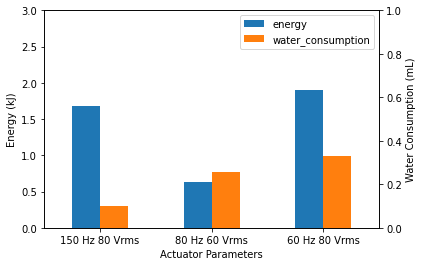

In [5]:
plt.figure()
ax=results_df.plot(kind='bar', y = ['energy', 'water_consumption'], secondary_y='water_consumption', rot=0, mark_right=False)
ax.set_ylim(0, 3)
fig=ax.get_figure()
ax=fig.get_axes()
ax[1].set_ylim(0, 1)
ax[0].set_ylabel('Energy (kJ)')
ax[1].set_ylabel('Water Consumption (mL)')

## Get Scores

In [6]:
normalized_inverse_energies = min_max_normalization(inverse_energy_dict)
normalized_inverse_water = min_max_normalization(inverse_water_consumption_dict)
normalized_cleaning_speeds = min_max_normalization(cleaning_speed_dict)
dict_array = [normalized_cleaning_speeds, normalized_inverse_energies, normalized_inverse_water]
weight_array = [0.7, 0.2, 0.1]
scores = get_scores(dict_array, weight_array)[0]
scores_df = pd.DataFrame([scores]).T
scores_df.columns = ['Scores']
scores_df.index.name = 'Actuator Parameters'
scores_df.sort_values(by = 'Scores', ascending=False)

,Scores
Actuator Parameters,
80 Hz 60 Vrms,0.912759
150 Hz 80 Vrms,0.449598
60 Hz 80 Vrms,0.000000


## Score Plots

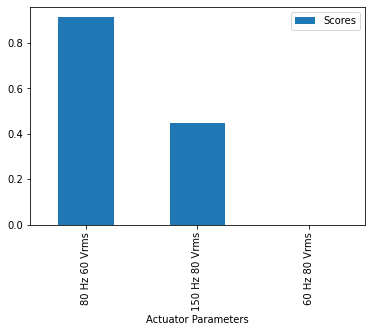

In [7]:
scores_df.sort_values(by = 'Scores', ascending=False).plot(y = 'Scores', kind = 'bar')
plt.show()

In [8]:
with pd.ExcelWriter('Seperated Cleaning Results.xlsx', engine = 'openpyxl') as writer:
    for name in name_list:
        df = df_dict[name]
        df.to_excel(writer, sheet_name = name)
    writer.save()
print('Completed')

Completed
